<a href="https://colab.research.google.com/github/Ciph3r007/Variational-Autoencoder-for-CelebA-Dataset/blob/main/VAE_for_CelebA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE for the CelebA dataset

- [1:   Setting up environment](#1)
- [2:   Loading Dataset](#2)
- [3:   Prior and Regularizer for KL Divergence](#3)
- [4:   Model Architecture](#4)
    - [4.1:   Encoder](#4.1)
    - [4.2:   Decoder](#4.2)
    - [4.3:   VAE Model](#4.3)
- [5:   Training](#5)
- [6:   Experimenting with the Trained Model](#6)
    - [6.1:   Reconstructing Images](#6.1)
    - [6.2:   Generating New Images from Prior Distribution Samples](#6.2)
- [7:   Modifying Attributes](#7)
    - [7.1:   CelebA Image Attributes](#7.1)
    - [7.2:   Getting 'Attribute Vector' of 'Smiling'](#7.2)
    - [7.3:   Adding Smile using the Attribute Vector](#7.3)

<a name="1"></a>
# 1. Setting up environment

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D, 
                                     UpSampling2D, BatchNormalization)
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/colab_data/VAE_for_CelebA

In [ ]:
# import zipfile
# with zipfile.ZipFile("CelebA subset.zip","r") as zip_ref:
#    zip_ref.extractall('data')

<a name="2"></a>
# 2. Loading Dataset

This subset of CelebA consists of 10,000 training images, 1000 validation images and 1000 test images, while full dataset has more than 200k images.

In [ ]:
def load_image(filepath):
    raw_img = tf.io.read_file(filepath) 
    img_tensor_int = tf.image.decode_jpeg(raw_img, channels=3)
    img_tensor_flt = tf.image.convert_image_dtype(img_tensor_int, tf.float32)
    return img_tensor_flt, img_tensor_flt

def load_dataset(split):
    train_list_ds = tf.data.Dataset.list_files('data/{}/*.jpg'.format(split), shuffle=False)
    train_ds = train_list_ds.map(load_image)
    return train_ds

In [ ]:
train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')

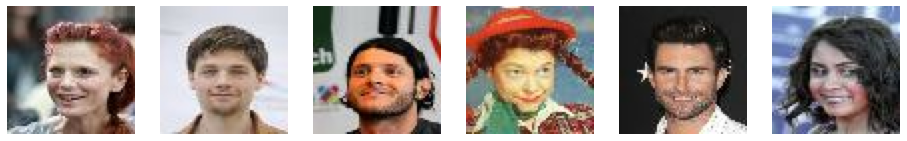

In [ ]:
f, axs = plt.subplots(1, 6, figsize=(16, 3))

for i, image in enumerate(train_ds.take(6)):
    axs[i].imshow(image[0])
    axs[i].axis('off')

In [ ]:
batch_size = 32

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

<a name="3"></a>
# 3. Prior and Regularizer for KL Divergence

In [ ]:
def get_prior(num_modes, latent_dim):
    probs = [1./num_modes] * num_modes
    mixture = tfd.Categorical(probs=probs)

    prior = tfd.MixtureSameFamily(
        mixture_distribution=mixture,
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(
                tf.random.normal((num_modes, latent_dim)),
                trainable=True, 
                dtype=tf.float32
                ),
            scale_diag=tfp.util.TransformedVariable(
                initial_value=tf.ones((num_modes, latent_dim)),
                bijector=tfb.Softplus()
                )
            )
        )
    
    return prior

In [ ]:
# Mixture of 2 Gaussian Distribution is used for prior with latent size of 50

prior = get_prior(num_modes=2, latent_dim=50)
prior

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[50] dtype=float32>

In [ ]:
# KLD is calculated using Monte-Carlo Estimate of 3 samples

def get_kl_regularizer(prior):
    regularizer = tfpl.KLDivergenceRegularizer(
        prior,
        use_exact_kl=False,
        weight=1.0, 
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )

    return regularizer

In [ ]:
kl_regularizer = get_kl_regularizer(prior)

<a name="4"></a>
# 4. Model Architecture

<a name="4.1"></a>
## 4.1. Encoder

In [ ]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, 4, input_shape=(64, 64, 3), strides=2, padding='SAME', activation='relu'),
        BatchNormalization(),
        Conv2D(64, 4, strides=2, padding='SAME', activation='relu'),
        BatchNormalization(),
        Conv2D(128, 4, strides=2, padding='SAME', activation='relu'),
        BatchNormalization(),
        Conv2D(256, 4, strides=2, padding='SAME', activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])

    return encoder

In [ ]:
encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         5

<a name="4.2"></a>
## 4.2. Decoder

In [ ]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, input_shape=(latent_dim,), activation='relu'),
        Reshape((4, 4, 256)),
        UpSampling2D(2),
        Conv2D(128, 3, padding='SAME', activation='relu'),
        UpSampling2D(2),
        Conv2D(64, 3, padding='SAME', activation='relu'),
        UpSampling2D(2),
        Conv2D(32, 3, padding='SAME', activation='relu'),
        UpSampling2D(2),
        Conv2D(128, 3, padding='SAME', activation='relu'),
        Conv2D(3, 3, padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli((64, 64, 3))
    ])

    return decoder

In [ ]:
decoder = get_decoder(latent_dim=50)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              208896    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         295040    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)       

<a name="4.3"></a>
## 4.3. VAE Model

In [ ]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

<a name="5"></a>
# 5. Training

In [ ]:
TRAIN = False

In [ ]:
def reconstruction_loss(batch_of_images, decoding_dist):
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [ ]:
if Train:
  vae.fit(train_ds, validation_data=val_ds, epochs=20)
  vae.save_weights('model/')
else:
  ckpt = tf.train.Checkpoint(model=vae)
  ckpt.restore(tf.train.latest_checkpoint('model/'))

In [ ]:
test_loss = vae.evaluate(test_ds)
print("Test loss: {}".format(test_loss))

32/32 [==============================] - 184s 5s/step - loss: 6157.8745
Test loss: 6157.87451171875


<a name="6"></a>
# 6. Experimenting with the Trained Model

<a name="6.1"></a>
## 6.1. Reconstructing Images

In [ ]:
def reconstruct(encoder, decoder, batch_of_images):
  z = encoder(batch_of_images).mean()
  image_out = decoder(z).mean()
  
  return image_out

In [ ]:
N = 7
files = [f for f in os.listdir('./data/test/') if f.endswith('.jpg')]
num_test_files = len(files)
test_ds_for_reconstructions = load_dataset('test')
for all_test_images, _ in test_ds_for_reconstructions.batch(num_test_files).take(1):
    all_test_images_np = all_test_images.numpy()
example_images = all_test_images_np[np.random.choice(num_test_files, N, replace=False)]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

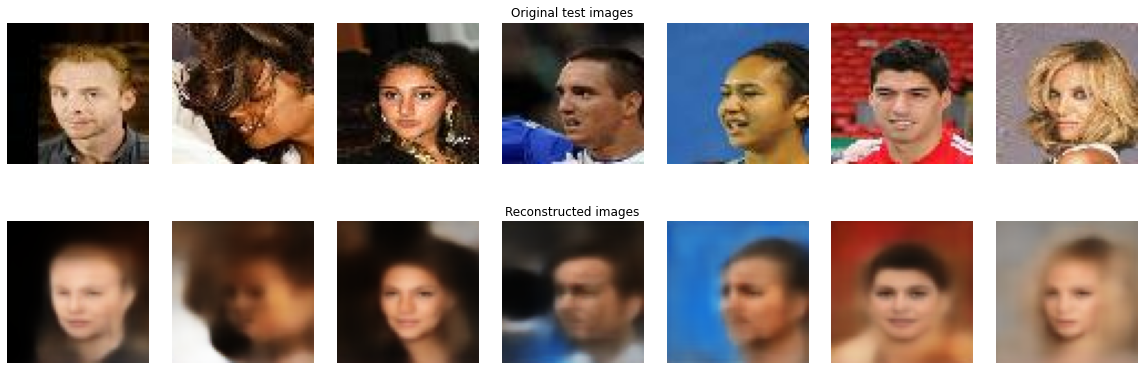

In [ ]:
f, axs = plt.subplots(2, N, figsize=(16, 6))
axs[0, N // 2].set_title("Original test images")
axs[1, N // 2].set_title("Reconstructed images")
for j in range(N):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
    
plt.tight_layout();

<a name="6.2"></a>
## 6.2. Generating New Images from Prior Distribution Samples

In [ ]:
def generate_images(prior, decoder, n_samples):
  z = prior.sample(n_samples)

  return decoder(z).mean()

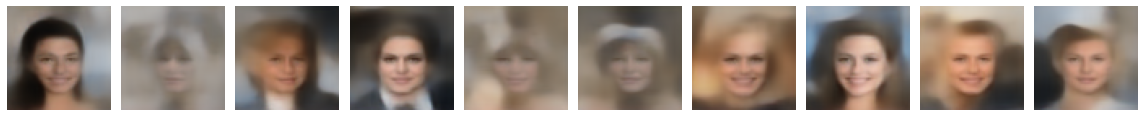

In [ ]:
n_samples = 10
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
  axs[j].imshow(sampled_images[j])
  axs[j].axis('off')
    
plt.tight_layout();

<a name="7"></a>
# 7. Modifying Attributes

The CelebA dataset also comes with some attributes related to the images.
These can be used to modify attributes by tweaking latent space.

<a name="7.1"></a>
## 7.1. CelebA Image Attributes

In [ ]:
def load_labels_and_image_arrays(split):
  dataset = load_dataset(split)
  files = [f for f in os.listdir('data/{}/'.format(split)) if f.endswith('.jpg')]
  
  for all_images, _ in dataset.batch(len(files)).take(1):
      all_images_np = all_images.numpy()

  labels = pd.read_csv('data/list_attr_celeba_subset.csv')
  labels = labels[labels['image_id'].isin(files)]
  return labels, all_images_np

In [ ]:
train_labels, training_subset = load_labels_and_image_arrays('train')

In [ ]:
train_labels.columns[2:]

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
train_labels.sample(5)

,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
5536,5536,090764.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,1,-1,1,-1,-1,-1
2973,2973,049621.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,1,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,-1,-1
5261,5261,086520.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3475,3475,057449.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,1
9675,9675,157731.jpg,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1


<a name="7.2"></a>
## 7.2. Getting 'Attribute Vector' of 'Smiling'

In [ ]:
attribute = 'Smiling'

# Separating the images into those that have the attribute, and those that don't
attribute_mask = (train_labels[attribute] == 1)
images_with_attribute = training_subset[attribute_mask]

not_attribute_mask = (train_labels[attribute] == -1)
images_without_attribute = training_subset[not_attribute_mask]

In [ ]:
# Encode the images with and without the chosen attribute

encoded_images_with_attribute = encoder(images_with_attribute)
encoded_images_without_attribute = encoder(images_without_attribute)

In [ ]:
# Average the latent vectors for each batch of encodings

mean_encoded_images_with_attribute = tf.reduce_mean(encoded_images_with_attribute.mean(), 
                                                    axis=0, keepdims=True)
mean_encoded_images_without_attribute = tf.reduce_mean(encoded_images_without_attribute.mean(), 
                                                    axis=0, keepdims=True)

In [ ]:
# Get the attribute vector

attribute_vector = mean_encoded_images_with_attribute -  mean_encoded_images_without_attribute

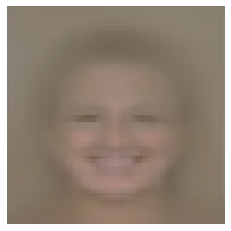

In [ ]:
# Visualing the attribute vector

decoded_a = decoder(attribute_vector).mean()
plt.imshow(decoded_a.numpy().squeeze())
plt.axis('off');

<a name="7.3"></a>
## 7.3. Adding Smile using the Attribute Vector

In [ ]:
n_examples = 7
sampled_inx = np.random.choice(images_without_attribute.shape[0], n_examples, replace=False)
sample_images_without_attribute = images_without_attribute[sampled_inx]
sample_images_encodings = encoder(sample_images_without_attribute)
sample_images_reconstructions = decoder(sample_images_encodings).mean()

k = 2.5  # Weighting of attribute vector
modified_sample_images_encodings = sample_images_encodings + (k * attribute_vector)
modified_reconstructions = decoder(modified_sample_images_encodings).mean()

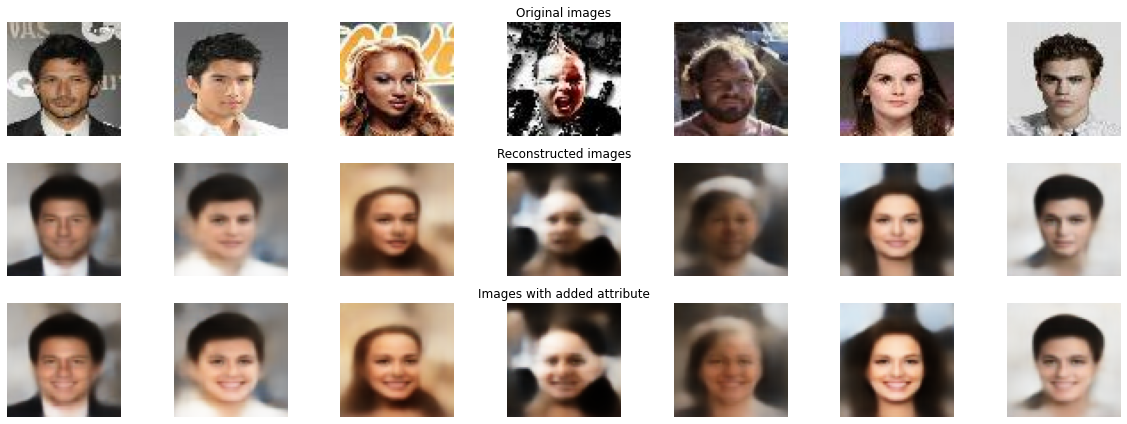

In [ ]:
f, axs = plt.subplots(3, n_examples, figsize=(16, 6))
axs[0, n_examples // 2].set_title("Original images")
axs[1, n_examples // 2].set_title("Reconstructed images")
axs[2, n_examples // 2].set_title("Images with added attribute")
for j in range(n_examples):
    axs[0, j].imshow(sample_images_without_attribute[j])
    axs[1, j].imshow(sample_images_reconstructions[j])
    axs[2, j].imshow(modified_reconstructions[j])
    for ax in axs[:, j]: ax.axis('off')
    
plt.tight_layout();